In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from matplotlib.pylab import rcParams
from scipy.integrate import solve_ivp
import math
from scipy.special import hermitenorm as hermite
import scipy.integrate as integrate
from sklearn.linear_model import LinearRegression
from NormalScoreTransform import *
from numpy.polynomial.hermite_e import hermeval, hermegauss
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from numpy.polynomial.legendre import legval, leggauss
from scipy.special import legendre 

## Creating Data

In [2]:
N = 500 # Sample size
N_mc = 10000
d = 1  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # number of terms in PCE

In [3]:
# Mixture of Gaussian and log-Gaussian
z = np.random.uniform(0, 1, N) < 0.6 # assume mixture coefficients are (0.8,0.2)
dat = np.zeros(N)
for i in range(N):
    if z[i] == True:
        dat[i] = np.random.normal(1.5, 0.5, 1)
    else:
        dat[i] = np.random.lognormal(1, 0.25, 1)
        
noise = np.random.normal(0, 0.01, N) 
dat += noise

In [4]:
# Mixture of Gaussian and log-Gaussian
z = np.random.uniform(0, 1, N) < 0.6 # assume mixture coefficients are (0.8,0.2)
dat2 = np.zeros(N)
for i in range(N):
    if z[i] == True:
        dat2[i] = np.random.normal(1.5, 0.5, 1)
    else:
        dat2[i] = np.random.lognormal(1, 0.25, 1)
        
noise = np.random.normal(0, 0.01, N) 
dat2 += noise

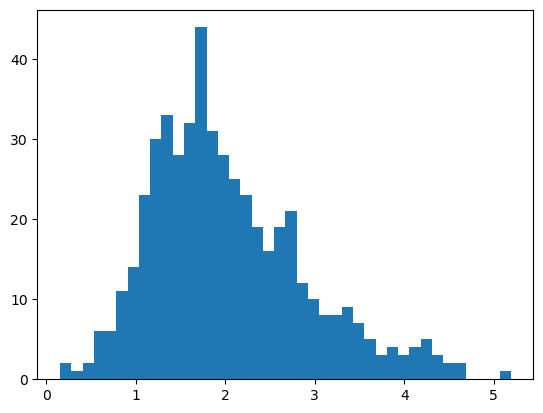

In [5]:
plt.hist(dat, bins = 40);

In [6]:
### PCE Data
### Transforming data to be normal

nst = NormalScoreTransform(
    dat, np.ones_like(dat),
    0, 30,
    0, 1,
    15, 1)
nst.create_transform_func()

dat_pce = nst.transform(dat)

In [7]:
### MC Data

z_mc = np.random.uniform(0, 1, N_mc) < 0.6 # assume mixture coefficients are (0.8,0.2)
dat_mc = np.zeros(N_mc)
for i in range(N_mc):
    if z_mc[i] == True:
        dat_mc[i] = np.random.normal(1.5, 0.5, 1)
    else:
        dat_mc[i] = np.random.lognormal(1, 0.25, 1)

## PCE

### PCE using Gauss Quadrature

In [8]:
#### This is assuming data is normal but not standard normal
# ?????????? should the weights be the same for all calculations of the constants c_i's ??

n_quad = 32
nodes = hermegauss(n_quad)[0] # roots
w = hermegauss(n_quad)[1]
c_pce = np.zeros(n)
for i in range(n):
    c_pce[i] = np.dot(w, np.exp(-np.mean(dat)-np.std(dat)*nodes)*hermite(i)(nodes))\
    /(np.sqrt(2*np.pi)*math.factorial(i))

In [9]:
y_PCE = np.mean(hermeval((dat-np.mean(dat))/np.std(dat), c_pce))
y_PCE

0.1768259497880763

In [10]:
#### This is assuming data is not normal so we transform it using score transform
## Problem is... I think we need to transform it back at some point but getting error in function

n_quad = n
nodes = hermegauss(n_quad)[0] # roots
weights = hermegauss(n_quad)[1]
w = np.zeros(n+1)
for i in range(n+1):
    hermpoly_coef = np.zeros(i+1)
    hermpoly_coef[-1] = 1
    w[i] = np.dot(weights, np.exp(-nodes)*hermeval(nodes, hermpoly_coef))/(np.sqrt(2*np.pi)*math.factorial(i))

In [11]:
w_t = nst.back_transform(w)
#### Try transforming w instead ???? 

In [12]:
np.mean(hermeval(dat_pce, w_t))

3.011847195388228

### Making a Function for PCE

In [13]:
def PCE(p, dat):
    #### This is assuming data is normal but not standard normal
    # ?????????? should the weights be the same for all calculations of the constants c_i's ??
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))
    
    n_quad = 32
    nodes = hermegauss(n_quad)[0] # roots
    w = hermegauss(n_quad)[1]
    c_pce = np.zeros(n)
    for i in range(n):
        c_pce[i] = np.dot(w, np.exp(-np.mean(dat)-np.std(dat)*nodes)*hermite(i)(nodes))\
        /(np.sqrt(2*np.pi)*math.factorial(i))
        
    return hermeval((dat-np.mean(dat))/np.std(dat), c_pce)

In [14]:
np.mean(PCE(6, dat))

0.1768259497880763

## MC

In [15]:
y_mc = np.mean(np.exp(-dat_mc*1))
y_mc_var = np.var(np.exp(-dat_mc))

y_mc

0.18320337679753418

## aPCE

In [16]:
#### Calculating the Orthogonal Polynomials
P = np.zeros((p+1, p+1))

P[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(dat**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P[i, :] = a.transpose()

In [17]:
## Checking Polynomials we created are orthogonal
def Pol_eval(coeff, x):
    deg = coeff.shape[0]
    val = 0
    for i in range(deg):
        val += coeff[i]*x**i
        
    return val

In [18]:
def Int_eval(coeff1, coeff2, dat):
    s = np.mean(Pol_eval(coeff1, dat)*Pol_eval(coeff2, dat))
    return s

In [19]:
for i in range(p+1):
    print(Int_eval(P[3,:], P[i,:], dat))

3.751665644813329e-15
-5.4711790653527716e-15
-9.521272659185343e-15
1.602711651723381
-1.3464500625559595e-12
1.1243628250667825e-13
5.951829962214106e-11


In [20]:
P_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P_norm[i,:] = P[i,:]/np.sqrt(Int_eval(P[i,:], P[i,:], dat))

In [21]:
P_norm

array([[  1.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [ -2.35256223,   1.15600825,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ],
       [  4.76222542,  -4.73308145,   0.99593344,   0.        ,
          0.        ,   0.        ,   0.        ],
       [ -7.94675238,  12.76346031,  -5.86878111,   0.78990034,
          0.        ,   0.        ,   0.        ],
       [ 10.8875079 , -25.75143723,  19.37659506,  -5.67975287,
          0.56167956,   0.        ,   0.        ],
       [-13.98965522,  46.6417942 , -51.05595006,  24.15688859,
         -5.09898274,   0.39298326,   0.        ],
       [ 17.14289834, -80.3575963 , 123.02627147, -85.33016542,
         29.41969881,  -4.90104992,   0.31371929]])

In [22]:
for i in range(p+1):
    print(Int_eval(P_norm[3,:], P_norm[i,:], dat))

4.154898647357186e-15
-3.446132268436486e-15
-7.133849067031406e-15
0.9999999999999997
-5.977369710308266e-13
6.693312570860144e-14
1.4665786807199764e-11


### Checking Weights on Legendre Polynomials

In [23]:
legendre(2)

poly1d([ 1.5,  0. , -0.5])

In [24]:
np.roots(hermite(2))

array([-1.,  1.])

In [25]:
import scipy.integrate as integrate
import scipy.special as special

In [26]:
integrate.quad(lambda x: x**0, -np.inf, np.inf)[0]

/var/folders/6l/nmzh70mx64s3ykd63cty8kg80000gn/T/ipykernel_34692/1731710399.py:1: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(lambda x: x**0, -np.inf, np.inf)[0]


-2.0

In [27]:
# Finding the weights for c_i

## ???? For some reason, np.roots gives me the negative of the roots for the legendre polynomial
## ???? The weights are correct, but they are given in a different order
nodes_H = -1*np.roots(legendre(p+1))
V_H = np.zeros((p+1,p+1))
for i in range(p+1):
    V_H[i,:] = nodes_H**i
b_cond_H = np.zeros(p+1)
for i in range(p+1):
    b_cond_H[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
w_s_H = np.linalg.inv(V_H)@b_cond_H

In [28]:
w_s_H

array([0.12948497, 0.27970539, 0.38183005, 0.12948497, 0.27970539,
       0.38183005, 0.41795918])

In [29]:
np.roots(legendre(p+1))

array([ 0.94910791,  0.74153119,  0.40584515, -0.94910791, -0.74153119,
       -0.40584515,  0.        ])

In [30]:
leggauss(p+1)

(array([-0.94910791, -0.74153119, -0.40584515,  0.        ,  0.40584515,
         0.74153119,  0.94910791]),
 array([0.12948497, 0.27970539, 0.38183005, 0.41795918, 0.38183005,
        0.27970539, 0.12948497]))

### aPCE using Gauss Quadrature

In [31]:
# Finding the weights for c_i
nodes = np.roots(P_norm[-1][::-1])
V = np.zeros((p,p))
for i in range(p):
    V[i,:] = nodes**i
b_cond = np.zeros(p)
for i in range(p):
    b_cond[i] = np.mean(dat**i)
w_s = np.linalg.inv(V)@b_cond

In [32]:
b_cond

array([  1.        ,   2.0350739 ,   4.8898299 ,  13.50741121,
        41.8193492 , 141.64516836])

In [33]:
np.roots(P_norm[-1][::-1])

array([5.06024541, 4.10507198, 2.9630664 , 1.94357232, 1.15495058,
       0.39549881])

In [34]:
P_norm[-1][::-1]

array([  0.31371929,  -4.90104992,  29.41969881, -85.33016542,
       123.02627147, -80.3575963 ,  17.14289834])

In [35]:
c = np.zeros(p+1)
for i in range(p+1):
    c[i] = np.dot(w_s, np.exp(-nodes)*Pol_eval(P_norm[i,:], nodes))

In [36]:
c

array([ 1.76779951e-01, -1.11693707e-01,  5.68292355e-02, -2.21637607e-02,
        7.12137632e-03, -1.88399206e-03, -1.05786328e-14])

In [37]:
y_aPCE = np.mean(c[0]*Pol_eval(P_norm[0,:], dat) \
        + c[1]*Pol_eval(P_norm[1,:], dat) \
        + c[2]*Pol_eval(P_norm[2,:], dat) \
        + c[3]*Pol_eval(P_norm[3,:], dat) \
        + c[4]*Pol_eval(P_norm[4,:], dat) \
        + c[5]*Pol_eval(P_norm[5,:], dat) \
        + c[6]*Pol_eval(P_norm[6,:], dat))

y_aPCE

0.1767799505018105

In [38]:
y_pce = c[0]*Pol_eval(P_norm[0,:], dat2) \
        + c[1]*Pol_eval(P_norm[1,:], dat2) \
        + c[2]*Pol_eval(P_norm[2,:], dat2) \
        + c[3]*Pol_eval(P_norm[3,:], dat2) \
        + c[4]*Pol_eval(P_norm[4,:], dat2) \
        + c[5]*Pol_eval(P_norm[5,:], dat2) \
        + c[6]*Pol_eval(P_norm[6,:], dat2)
y_true = np.exp(-dat2)

In [39]:
np.mean(y_pce)

0.17536696779036715

In [40]:
def evaluate_pce_1D(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               Pol_eval(P_norm[pce_index[i,0],:], x)
    return val

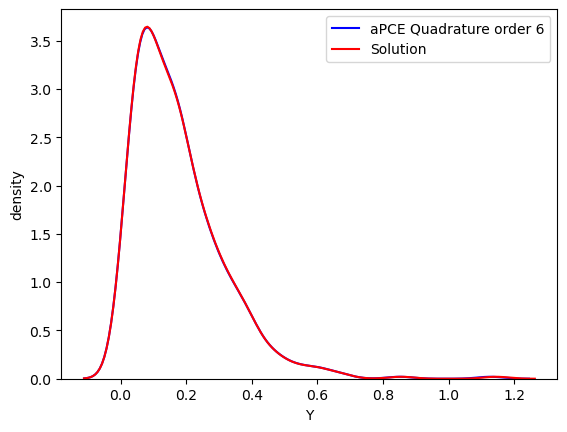

In [41]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_pce, color='b', label='aPCE Quadrature order 6')
sns.kdeplot(y_true, color='r', label='Solution')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

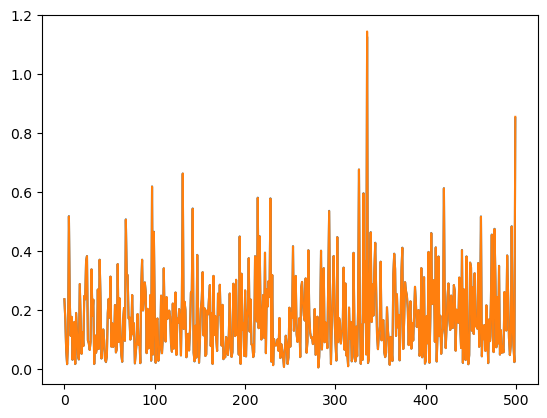

In [42]:
plt.plot(y_pce)
plt.plot(y_true)

### Using Linear Regression to Calculate the Coefficients

In [43]:
Phi = np.zeros((N, n))

for i in range(n):
    Phi[:,i] =  Pol_eval(P_norm[i,:], dat)

In [44]:
model = LinearRegression(fit_intercept = False).fit(Phi, np.exp(-dat))

In [45]:
model.coef_

array([ 0.17677995, -0.11169373,  0.05682946, -0.02216561,  0.00713344,
       -0.00195444,  0.0004023 ])

In [46]:
Phi2 = np.zeros((N, n))

for i in range(n):
    Phi2[:,i] =  Pol_eval(P_norm[i,:], dat2)

In [47]:
y_aPCE_LR = Phi2@model.coef_

In [48]:
np.mean(y_aPCE_LR)

0.17538800830583118

In [49]:
y_aPCE_LR.shape

(500,)

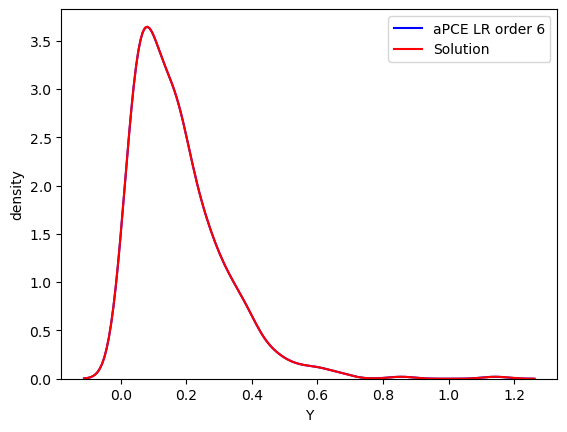

In [50]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_aPCE_LR, color='b', label='aPCE LR order 6')
sns.kdeplot(y_true, color='r', label='Solution')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

In [51]:
(np.mean(y_aPCE_LR)-y_mc)/y_mc

-0.042659522047675445

### Multidimensional aPCE on the Ishigami Function

In [52]:
N = 500 # Sample size
d = 3  # d --> number of random variables
p = 6 # p --> degree of PCE polynomial
n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p))) # number of terms in PCE

In [53]:
def Ishigami_Function(x1,x2,x3):
    return np.c_[np.sin(x1) + 7*(np.sin(x2))**2 + 0.1*x3**4*np.sin(x1)]

In [54]:
# Generating data x_1, x_2, and x_3
Z = np.random.uniform(-np.pi,np.pi, size=(N,3))

x_1 = Z[:,0]
x_2 = Z[:,1]
x_3 = Z[:,2]

Y = np.c_[np.sin(x_1) + 7*(np.sin(x_2))**2 + 0.1*x_3**4*np.sin(x_1)]

In [55]:
#### Calculating the Orthogonal Polynomials corresponding to x_1
P1 = np.zeros((p+1, p+1))

P1[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(x_1**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P1[i, :] = a.transpose()

In [56]:
q = 10

In [57]:
#### Calculating the Orthogonal Polynomials corresponding to x_1
#### For Quadrature
P1_q = np.zeros((q+1, q+1))

P1_q[0,0] = 1

mu = np.zeros(2*q) 
for i in range(2*q): 
    mu[i] = np.mean(x_1**i)
    
mu_mat = np.zeros((q, q+1))
for i in range(q):
    mu_mat[i,:] = mu[i:(q+1+i)]
    
for i in range(1,q+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(q+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P1_q[i, :] = a.transpose()

In [58]:
#### Calculating the Orthogonal Polynomials corresponding to x_2
P2 = np.zeros((p+1, p+1))

P2[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(x_2**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P2[i, :] = a.transpose()

In [59]:
#### Calculating the Orthogonal Polynomials corresponding to x_2
#### For Quadrature
P2_q = np.zeros((q+1, q+1))

P2_q[0,0] = 1

mu = np.zeros(2*q) 
for i in range(2*q): 
    mu[i] = np.mean(x_2**i)
    
mu_mat = np.zeros((q, q+1))
for i in range(q):
    mu_mat[i,:] = mu[i:(q+1+i)]
    
for i in range(1,q+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(q+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P2_q[i, :] = a.transpose()

In [60]:
#### Calculating the Orthogonal Polynomials corresponding to x_3
P3 = np.zeros((p+1, p+1))

P3[0,0] = 1

mu = np.zeros(2*p) 
for i in range(2*p): 
    mu[i] = np.mean(x_3**i)
    
mu_mat = np.zeros((p, p+1))
for i in range(p):
    mu_mat[i,:] = mu[i:(p+1+i)]
    
for i in range(1,p+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(p+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P3[i, :] = a.transpose()

In [61]:
#### Calculating the Orthogonal Polynomials corresponding to x_1
#### For Quadrature
P3_q = np.zeros((q+1, q+1))

P3_q[0,0] = 1

mu = np.zeros(2*q) 
for i in range(2*q): 
    mu[i] = np.mean(x_1**i)
    
mu_mat = np.zeros((q, q+1))
for i in range(q):
    mu_mat[i,:] = mu[i:(q+1+i)]
    
for i in range(1,q+1):
    A = np.zeros((i+1, i+1))
    A[-1,-1] = 1
    A[0:i,:] = mu_mat[0:i, 0:i+1]
    b = A[-1]
    a = np.zeros(q+1)
    a[0:i+1] = np.linalg.inv(A)@b
    P3_q[i, :] = a.transpose()

In [62]:
P1_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P1_norm[i,:] = P1[i,:]/np.sqrt(Int_eval(P1[i,:], P1[i,:], x_1))

In [63]:
P1_q_norm = np.zeros((q+1, q+1))
for i in range(q+1):
    P1_q_norm[i,:] = P1_q[i,:]/np.sqrt(Int_eval(P1_q[i,:], P1_q[i,:], x_1))

In [64]:
P2_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P2_norm[i,:] = P2[i,:]/np.sqrt(Int_eval(P2[i,:], P2[i,:], x_2))

In [65]:
P2_q_norm = np.zeros((q+1, q+1))
for i in range(q+1):
    P2_q_norm[i,:] = P2_q[i,:]/np.sqrt(Int_eval(P2_q[i,:], P2_q[i,:], x_1))

In [66]:
P3_norm = np.zeros((p+1, p+1))
for i in range(p+1):
    P3_norm[i,:] = P3[i,:]/np.sqrt(Int_eval(P3[i,:], P3[i,:], x_3))

In [67]:
P3_q_norm = np.zeros((q+1, q+1))
for i in range(q+1):
    P3_q_norm[i,:] = P3_q[i,:]/np.sqrt(Int_eval(P3_q[i,:], P3_q[i,:], x_1))

In [68]:
def multivariate_pce_index(d, max_deg):
    """
    Generate all the d-dimensional polynomial indices with the 
    constraint that the sum of the indexes is <= max_deg
    
    input:
    d: int, number of random variables
    max_deg: int, the max degree allowed
    
    return: 
    2d array with shape[1] equal to d, the multivariate indices
    """
    maxRange = max_deg*np.ones(d, dtype = 'int')
    index = np.array([i for i in product(*(range(i + 1) for i in maxRange)) if sum(i) <= max_deg])
    return index

In [69]:
def pce_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """

    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = np.roots(P1_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes1**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_1**i)
    w_1 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_2
    nodes2 = np.roots(P2_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes2**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_2**i)
    w_2 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_3
    nodes3 = np.roots(P3_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes3**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_3**i)
    w_3 = np.linalg.inv(V)@b_cond
        
    # the index is for computing the quadrature
    quad_index = multivariate_pce_index(3, n_quad-1)
        
    for i in range(pce_coef.size):
        for j in range(quad_index.shape[0]):
            pce_coef[i] += Ishigami_Function(nodes1[quad_index[j,0]], 
                                             nodes2[quad_index[j,1]], 
                                             nodes3[quad_index[j,2]])*\
            w_1[quad_index[j,0]]*w_2[quad_index[j,1]]*w_3[quad_index[j,2]]*\
            Pol_eval(P1_norm[pce_index[i,0],:], nodes1[quad_index[j,0]])*\
            Pol_eval(P2_norm[pce_index[i,1],:], nodes2[quad_index[j,1]])*\
            Pol_eval(P3_norm[pce_index[i,2],:], nodes3[quad_index[j,2]]) 

    return pce_coef

In [103]:
def aPCE_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """
    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = np.roots(P1_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes1**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_1**i)
    w_1 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_2
    nodes2 = np.roots(P2_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes2**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_2**i)
    w_2 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_3
    nodes3 = np.roots(P3_q_norm[-1][::-1])
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes3**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = np.mean(x_3**i)
    w_3 = np.linalg.inv(V)@b_cond
        
    # the index is for computing the quadrature
    #quad_index = multivariate_pce_index(3, n_quad-1)
    for i in range(pce_coef.size):
        for j in range(n_quad):
            for k in range(n_quad):
                for r in range(n_quad):
                    pce_coef[i] += w_1[j]*w_2[k]*w_3[r]*\
                                   Ishigami_Function(nodes1[j], 
                                                     nodes2[k], 
                                                     nodes3[r])*\
                        Pol_eval(P1_norm[pce_index[i,0],:], nodes1[j])*\
                        Pol_eval(P2_norm[pce_index[i,1],:], nodes2[k])*\
                        Pol_eval(P3_norm[pce_index[i,2],:], nodes3[r])

    return pce_coef

In [71]:
pce_coef = pce_Ishigami_Quadrature(3, p, q)

In [72]:
def evaluate_aPCE_Ishigami(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
               Pol_eval(P1_norm[pce_index[i,0],:], x[:,0])*\
               Pol_eval(P2_norm[pce_index[i,1],:],x[:,1])*\
               Pol_eval(P3_norm[pce_index[i,2],:], x[:,2])
    return val

In [73]:
sample = np.random.uniform(-np.pi,np.pi, size=(N,3))

y_aPCE = evaluate_aPCE_Ishigami(pce_coef, 3, p, sample)

y_true = Ishigami_Function(sample[:,0], sample[:,1], sample[:,2])

In [74]:
np.mean(y_aPCE)

0.11590248482941787

In [75]:
np.mean(y_true)

3.578924580345313

In [76]:
np.mean(np.abs((y_aPCE-y_true)/y_true))

1.2168991942038507

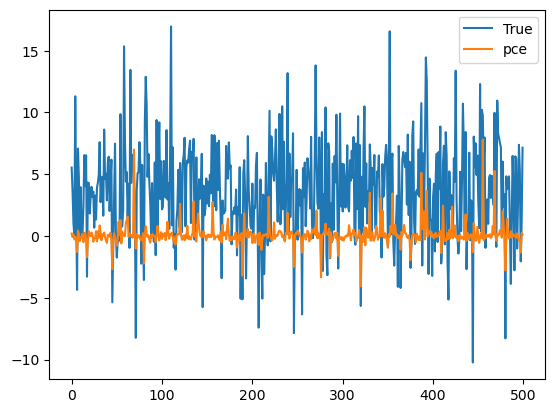

In [77]:
plt.plot(y_true, label = 'True')
plt.plot(y_aPCE, label = "pce")
plt.legend();

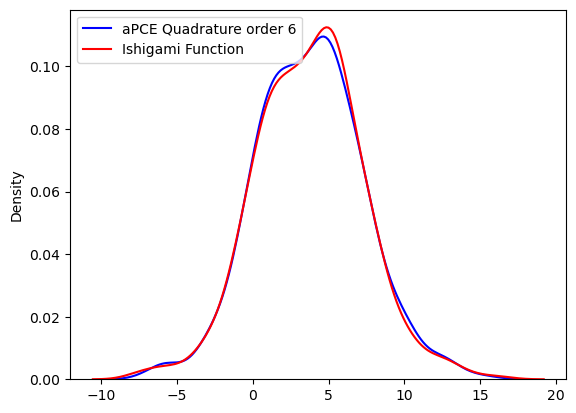

In [155]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_aPCE, color='b', label='aPCE Quadrature order 6')
sns.kdeplot(y_true.reshape(N), color='r', label='Ishigami Function')
plt.legend();

### PCE on Ishigami function

In [133]:
def PCE_Ishigami_Quadrature(d, max_deg, n_quad):
    """
    Compute the pce coefficients of the Ishigami Function
    input:
    d: int, number of parameters
    max_deg: int, the max degree so that individual degrees
             are not above it
    n_quad: int, number of quadrature points
    return:
    1d array, PCE coefficients
    """
    pce_index = multivariate_pce_index(d, max_deg)
    pce_coef = np.zeros(pce_index.shape[0])
    
    # quadrature
    # Finding the weights for x_1
    nodes1 = -1*np.roots(legendre(n_quad))
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes1**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
    w_1 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_2
    nodes2 = -1*np.roots(legendre(n_quad))
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes2**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
    w_2 = np.linalg.inv(V)@b_cond
    
    # Finding the weights for x_3
    nodes3 = -1*np.roots(legendre(n_quad))
    V = np.zeros((n_quad,n_quad))
    for i in range(n_quad):
        V[i,:] = nodes3**i
    b_cond = np.zeros(n_quad)
    for i in range(n_quad):
        b_cond[i] = integrate.quad(lambda x: x**i, -1, 1)[0]
    w_3 = np.linalg.inv(V)@b_cond
        
    # the index is for computing the quadrature
    #quad_index = multivariate_pce_index(3, n_quad-1)
    for i in range(pce_coef.size):
        for j in range(n_quad):
            for k in range(n_quad):
                for r in range(n_quad):
                    pce_coef[i] += w_1[j]*w_2[k]*w_3[r]*\
                                   Ishigami_Function(np.pi*nodes1[j], 
                                                     np.pi*nodes2[k], 
                                                     np.pi*nodes3[r])\
                    *legendre(pce_index[i][0])(nodes1[j]) \
                    *legendre(pce_index[i][1])(nodes2[k]) \
                    *legendre(pce_index[i][2])(nodes3[r])
        pce_coef[i] /= 2/(2*pce_index[i,0]+1)
        pce_coef[i] /= 2/(2*pce_index[i,1]+1)
        pce_coef[i] /= 2/(2*pce_index[i,2]+1)

    return pce_coef

In [134]:
pce_coef2 = PCE_Ishigami_Quadrature(3, p, q)

In [135]:
def evaluate_PCE_Ishigami(pce_coef, d, max_deg, x):
    """
    evaluate pce expansion with maximum degree max_deg at the points x
    for Black-Scholes
    input:
    pce_coef: 1d array, the pce coefficients
    d: int, the number of parameter
    max_deg: int, the maximum degree
    x: 2d array, the points where the pce is evaluated. x.shape[1] = 3
    return
    val: 1d array of the same size as x.shape[0]
    """
    pce_index = multivariate_pce_index(d, max_deg)
    val = np.zeros(x.shape[0])
    for i in range(pce_index.shape[0]):    
        val += pce_coef[i]*\
                     legendre(pce_index[i][0])(x[:,0]) \
                    *legendre(pce_index[i][1])(x[:,1]) \
                    *legendre(pce_index[i][2])(x[:,2])
    return val

In [138]:
y_PCE = evaluate_PCE_Ishigami(pce_coef2, 3, p, sample/np.pi)

In [140]:
np.mean(y_true)

3.7385776460412172

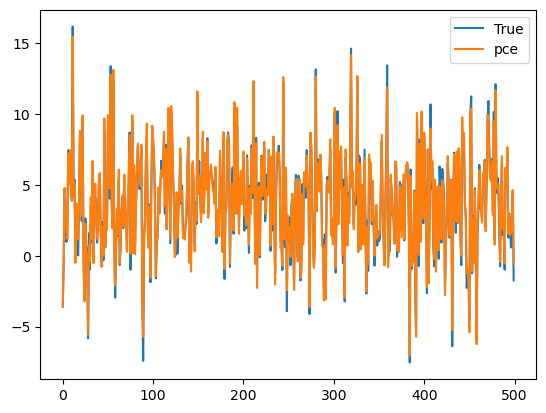

In [141]:
plt.plot(y_true, label = 'True')
plt.plot(y_PCE, label = "pce")
plt.legend();

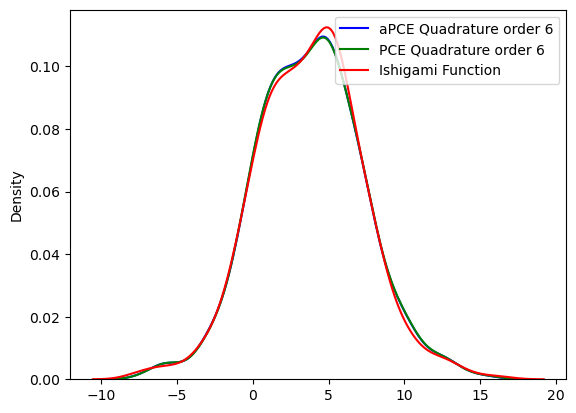

In [154]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(y_aPCE, color='b', label='aPCE Quadrature order 6')
sns.kdeplot(y_PCE, color='g', label='PCE Quadrature order 6')
sns.kdeplot(y_true.reshape(N), color='r', label='Ishigami Function')
plt.legend();

In [153]:
(y_true.reshape(N)).shape

(500,)

### Using LR

In [122]:
index = multivariate_pce_index(3, p)
Phi = np.zeros((N, n))

for i in range(n):
    Phi[:,i] =  Pol_eval(P1_norm[index[i][0],:], x_1) \
               *Pol_eval(P2_norm[index[i][1],:], x_2) \
               *Pol_eval(P3_norm[index[i][2],:], x_3)

In [123]:
model = LinearRegression(fit_intercept = False).fit(Phi, Y)

In [124]:
np.mean(Phi@model.coef_.transpose())

3.4753114674428

In [125]:
Y_pce = Phi@model.coef_.transpose()

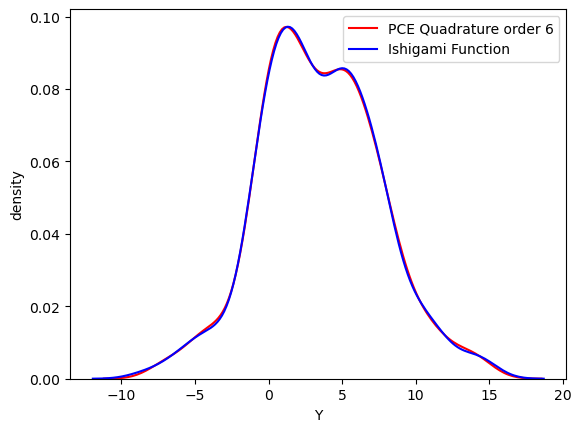

In [126]:
#plt.rcParams['figure.figsize'] = (6, 6)
sns.kdeplot(Y_pce.reshape(N), color = 'r', label='PCE Quadrature order 6')
sns.kdeplot(Y.reshape(N), color = 'b', label='Ishigami Function')
plt.legend()
plt.xlabel('Y')
plt.ylabel('density');

## Making one Function to Calculate any Degree n

In [26]:
## Checking Polynomials we created are orthogonal
def Pol_eval(coeff, x):
    deg = coeff.shape[0]
    val = 0
    for i in range(deg):
        val += coeff[i]*x**i
        
    return val

def Int_eval(coeff1, coeff2, dat):
    s = np.mean(Pol_eval(coeff1, dat)*Pol_eval(coeff2, dat))
    return s

In [27]:
def aPCE(p, dat):
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

    #### Calculating the Orthogonal Polynomials
    P = np.zeros((p+1, p+1))

    P[0,0] = 1

    mu = np.zeros(2*p) 
    for i in range(2*p): 
        mu[i] = np.mean(dat**i)

    mu_mat = np.zeros((p, p+1))
    for i in range(p):
        mu_mat[i,:] = mu[i:(p+1+i)]

    for i in range(1,p+1):
        A = np.zeros((i+1, i+1))
        A[-1,-1] = 1
        A[0:i,:] = mu_mat[0:i, 0:i+1]
        b = A[-1]
        a = np.zeros(p+1)
        a[0:i+1] = np.linalg.inv(A)@b
        P[i, :] = a.transpose()
    
    P_norm = np.zeros((p+1, p+1))
    for i in range(p+1):
        P_norm[i,:] = P[i,:]/np.sqrt(Int_eval(P[i,:], P[i,:], dat))
    
    # Finding the weights for c_i
    nodes = np.roots(P_norm[-1][::-1])
    V = np.zeros((p,p))
    for i in range(p):
        V[i,:] = nodes**i
    b_cond = np.zeros(p)
    for i in range(p):
        b_cond[i] = np.mean(dat**i)
    w_s = np.linalg.inv(V)@b_cond

    c = np.zeros(p+1)
    for i in range(p+1):
        c[i] = np.dot(w_s, np.exp(-nodes)*Pol_eval(P_norm[i,:], nodes))
        
    r = 0
    for i in range(n):
        r += c[i]*Pol_eval(P_norm[i,:], dat)
    return r

In [52]:
def aPCE_LR(p, dat):
    n = int(math.factorial(d + p)/(math.factorial(d)*math.factorial(p)))

    #### Calculating the Orthogonal Polynomials
    P = np.zeros((p+1, p+1))

    P[0,0] = 1

    mu = np.zeros(2*p) 
    for i in range(2*p): 
        mu[i] = np.mean(dat**i)

    mu_mat = np.zeros((p, p+1))
    for i in range(p):
        mu_mat[i,:] = mu[i:(p+1+i)]

    for i in range(1,p+1):
        A = np.zeros((i+1, i+1))
        A[-1,-1] = 1
        A[0:i,:] = mu_mat[0:i, 0:i+1]
        b = A[-1]
        a = np.zeros(p+1)
        a[0:i+1] = np.linalg.inv(A)@b
        P[i, :] = a.transpose()
    
    P_norm = np.zeros((p+1, p+1))
    for i in range(p+1):
        P_norm[i,:] = P[i,:]/np.sqrt(Int_eval(P[i,:], P[i,:], dat))
    
    # Finding the weights for c_i
    Phi = np.zeros((N, n))

    for i in range(n):
        Phi[:,i] =  Pol_eval(P_norm[i,:], dat)
    print(Phi.shape)

    model = LinearRegression(fit_intercept = False).fit(Phi, np.exp(-dat))
    return Phi@np.c_[model.coef_]

## Solutions

In [56]:
aPCE_mean = np.zeros(6)
PCE_mean = np.zeros(6)
aPCE_var = np.zeros(6)
PCE_var = np.zeros(6)

for i in range(1,7):
    aPCE_mean[i-1] = np.mean(aPCE(i , dat))
    PCE_mean[i-1] = np.mean(PCE(i, dat))
    aPCE_var[i-1] = np.var(aPCE(i, dat))
    PCE_var[i-1] = np.var(PCE(i, dat))

In [57]:
err_aPCE = np.abs(aPCE_mean-y_mc)/np.abs(y_mc)
err_PCE = np.abs(PCE_mean-y_mc)/np.abs(y_mc)

err_aPCE_var = np.abs(aPCE_var-y_mc_var)/np.abs(y_mc_var)
err_PCE_var = np.abs(PCE_var-y_mc_var)/np.abs(y_mc_var)

In [58]:
aPCE_mean

array([0.13391747, 0.17949712, 0.18446302, 0.18476028, 0.18477074,
       0.18477096])

In [59]:
y_mc

0.17761563760791596

In [60]:
PCE_mean

array([0.20020131, 0.20020131, 0.18053077, 0.18405871, 0.18468611,
       0.18486346])

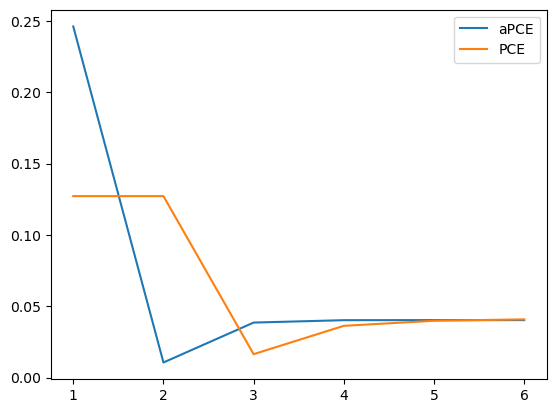

In [61]:
plt.plot(range(1,7), err_aPCE, label = "aPCE")
plt.plot(range(1,7), err_PCE, label = "PCE")
#plt.ylim(0, 10**(-1))
plt.legend()

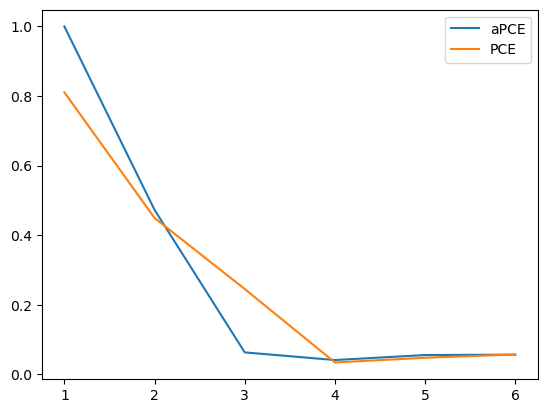

In [62]:
plt.plot(range(1,7), err_aPCE_var, label = "aPCE")
plt.plot(range(1,7), err_PCE_var, label = "PCE")
#plt.ylim(0, 10**(-1))
plt.legend()